In [1]:
!pip install findspark

In [1]:
import findspark
findspark.init()
print("findspark is working!")

findspark is working!


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, avg, when
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

os.environ["HADOOP_HOME"] = "C:/Users/gurra/Desktop/spark/spark-4.0.1-bin-hadoop3"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["HADOOP_HOME"], "bin")

spark = SparkSession.builder \
    .appName("PySparkStockTrendPredictor") \
    .config("spark.hadoop.fs.defaultFS", "file:///") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()
print("✅ Spark Session Started!")

✅ Spark Session Started!


In [13]:
file_path = "file:///C:/Users/gurra/Desktop/spark/GOOG.csv"
print(f"Reading file from: {file_path}")

# Verify file exists
if not os.path.exists("C:/Users/gurra/Desktop/spark/GOOG.csv"):
    print("❌ Error: GOOG.csv not found!")
    spark.stop()
    raise FileNotFoundError("Please ensure GOOG.csv is in C:/Users/gurra/Desktop/spark/")

# Read CSV
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert Date column to date type
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Show data sample
df.show(5)
print(f"Total records: {df.count()}")

Reading file from: file:///C:/Users/gurra/Desktop/spark/GOOG.csv
+----------+--------+--------+--------+--------+---------+---------+
|      Date|    Open|    High|     Low|   Close|Adj Close|   Volume|
+----------+--------+--------+--------+--------+---------+---------+
|2004-08-19|2.490664|2.591785|2.390042|2.499133| 2.499133|897427216|
|2004-08-20| 2.51582|2.716817|2.503118|2.697639| 2.697639|458857488|
|2004-08-23|2.758411|2.826406| 2.71607|2.724787| 2.724787|366857939|
|2004-08-24|2.770615|2.779581|2.579581| 2.61196|  2.61196|306396159|
|2004-08-25|2.614201|2.689918|2.587302|2.640104| 2.640104|184645512|
+----------+--------+--------+--------+--------+---------+---------+
only showing top 5 rows
Total records: 4858


In [15]:
for c in ["Open", "High", "Low", "Close", "Adj Close", "Volume"]:
    avg_val = df.select(avg(c)).collect()[0][0]
    df = df.na.fill({c: avg_val})

# Remove invalid or zero values
df_clean = df.filter((col("Open") > 0) & (col("High") > 0) & (col("Low") > 0) & 
                     (col("Close") > 0) & (col("Adj Close") > 0) & (col("Volume") > 0))

# Drop duplicate dates
df_clean = df_clean.dropDuplicates(["Date"])

print("✅ Data cleaned successfully!")
df_clean.show(5)

✅ Data cleaned successfully!
+----------+---------+---------+---------+---------+---------+---------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|
+----------+---------+---------+---------+---------+---------+---------+
|2005-06-06| 7.033387| 7.316327| 7.019439| 7.246339| 7.246339|904413304|
|2006-05-17| 9.230651|  9.46054| 9.220938| 9.327538| 9.327538|427347823|
|2007-04-20|12.217207|12.266522|  12.0055|12.016957|12.016957|488283372|
|2007-11-15|15.904636|16.127052|15.541746|15.682468|15.682468|279752666|
|2007-11-23| 16.68745|16.893679|16.640379|16.854326|16.854326|109958613|
+----------+---------+---------+---------+---------+---------+---------+
only showing top 5 rows


In [17]:
window_spec = Window.orderBy("Date").rowsBetween(-7, 0)
df_trend = df_clean.withColumn("MA_7", avg("Close").over(window_spec))

# Define simple trend prediction
df_trend = df_trend.withColumn("Trend",
    when(col("Close") > col("MA_7"), "Up")
    .when(col("Close") < col("MA_7"), "Down")
    .otherwise("Stable")
)

print("📈 Sample Predicted Trends:")
df_trend.select("Date", "Close", "MA_7", "Trend").show(10)

📈 Sample Predicted Trends:
+----------+--------+------------------+------+
|      Date|   Close|              MA_7| Trend|
+----------+--------+------------------+------+
|2004-08-19|2.499133|          2.499133|Stable|
|2004-08-20|2.697639|          2.598386|    Up|
|2004-08-23|2.724787|2.6405196666666666|    Up|
|2004-08-24| 2.61196|        2.63337975|  Down|
|2004-08-25|2.640104|2.6347245999999998|    Up|
|2004-08-26|2.687676| 2.643549833333333|    Up|
|2004-08-27| 2.64384| 2.643591285714286|    Up|
|2004-08-30|2.540727|        2.63073325|  Down|
|2004-08-31|2.549693|        2.63705325|  Down|
|2004-09-01|2.496891|2.6119597500000005|  Down|
+----------+--------+------------------+------+
only showing top 10 rows


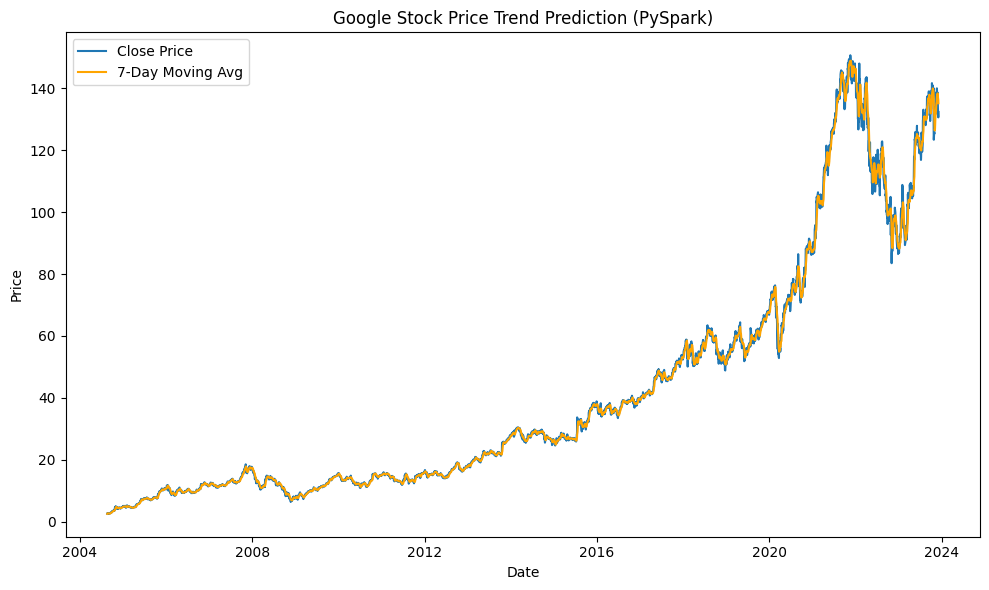

In [19]:
trend_pd = df_trend.select("Date", "Close", "MA_7", "Trend").toPandas()

plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_pd, x="Date", y="Close", label="Close Price")
sns.lineplot(data=trend_pd, x="Date", y="MA_7", label="7-Day Moving Avg", color="orange")
plt.title("Google Stock Price Trend Prediction (PySpark)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
output_path = "file:///C:/Users/gurra/Desktop/spark/stock_trend_predictions.csv"
df_trend.select("Date", "Close", "MA_7", "Trend") \
       .coalesce(1) \
       .write.mode("overwrite") \
       .option("header", "true") \
       .csv(output_path)

print(f"✅ Trend predictions saved to: {output_path}")

# Stop Spark session
spark.stop()
print("🚀 Project Complete! Check the saved CSV for trend predictions.")

✅ Trend predictions saved to: file:///C:/Users/gurra/Desktop/spark/stock_trend_predictions.csv
🚀 Project Complete! Check the saved CSV for trend predictions.
